# Fake News Detection: Binary Classification Model

In this project, we analyse the [ISOT Fake News Detection dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/) and develop machine learning models to classify news articles as fake or real. We draw inspiration from the [2024 paper](https://arxiv.org/html/2411.12703v1) by Karim et al.

## 1 Imports
We import relevant Python packages for data manipulation, visualisation, preprocessing and modeling.

In [1]:
# Operational packages
import pandas as pd
import numpy as np
import warnings
from datetime import datetime

# Visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer

# Machine Learning baseline models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore", category=FutureWarning)

We load the fake and real news articles into pandas DataFrames and assign them to the variables **fake_news** and **real_news**, respectively.

In [2]:
# import data
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

## 2 Data Exploration
### 2.1 Initial Exploratory Data Analysis
We begin by conducting an initial exploration of the dataset.

In [3]:
# check first 5 rows of fake news dataset
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
# check first 5 rows of real news dataset
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# check size of fake news dataset
fake_news.shape

(23481, 4)

In [6]:
# check size of real news dataset
real_news.shape

(21417, 4)

The fake news dataset contains 23,481 entries, each representing a fake news article. The real news dataset contains 21,417 entries, with each corresponding to a real news article. Both datasets share the same column structure.

### 2.2 Data Cleaning

We combine the real and fake news datasets into a single DataFrame and introduce a new column, **label**, to indicate the class of each article (0 for real news, 1 for fake news).

In [7]:
# combine datasets
fake_news['label'] = 1
real_news['label'] = 0
news_df = pd.concat([fake_news, real_news], ignore_index=True)

In [8]:
# check first 5 rows of news dataset
news_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [9]:
# check last 5 rows of news dataset
news_df.tail()

,title,text,subject,date,label
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0


In [10]:
# Check size of the new DataFrame
news_df.shape

(44898, 5)

We check the data types of the columns.

In [11]:
# Check data types of columns
news_df.dtypes

title      object
text       object
subject    object
date       object
label       int64
dtype: object

We convert the **date** column to a pandas *datetime64* type to enable easier time-based filtering and feature extraction.

In [12]:
# Strip leading/trailing whitespace from all entries in the date column
news_df['date'] = news_df['date'].astype(str).str.strip()

# Convert 'date' column to datetime
def parse_date(text):
    for fmt in ("%d-%b-%y", "%b %d, %Y", "%Y-%m-%d", "%d-%m-%Y", "%d %b %Y", "%B %d, %Y"):
        try:
            return datetime.strptime(text.strip(), fmt)
        except Exception:
            continue
    return pd.NaT

news_df['date_new'] = news_df['date'].apply(parse_date)

# Check data types of columns
news_df.dtypes

title               object
text                object
subject             object
date                object
label                int64
date_new    datetime64[ns]
dtype: object

We check for missing values.

In [13]:
# Check for missing values
news_df.isna().sum()

title        0
text         0
subject      0
date         0
label        0
date_new    10
dtype: int64

In [14]:
# Inspect entries with missing values
news_df[news_df['date_new'].isna()][['date', 'date_new']]

,date,date_new
9358,https://100percentfedup.com/served-roy-moore-v...,NaT
15507,https://100percentfedup.com/video-hillary-aske...,NaT
15508,https://100percentfedup.com/12-yr-old-black-co...,NaT
15839,https://fedup.wpengine.com/wp-content/uploads/...,NaT
15840,https://fedup.wpengine.com/wp-content/uploads/...,NaT
17432,https://fedup.wpengine.com/wp-content/uploads/...,NaT
17433,https://fedup.wpengine.com/wp-content/uploads/...,NaT
18933,MSNBC HOST Rudely Assumes Steel Worker Would N...,NaT
21869,https://fedup.wpengine.com/wp-content/uploads/...,NaT
21870,https://fedup.wpengine.com/wp-content/uploads/...,NaT


In [15]:
# Drop rows with missing 'date_new'
news_df_subset = news_df.dropna(subset=['date_new'])

# Drop the original 'date' column
news_df_subset2 = news_df_subset.drop(columns='date')

# Rename columns
news_df_subset3 = news_df_subset2.rename(columns={
    'title': 'headline',
    'text': 'article_text',
    'subject': 'category',
    'date_new': 'publication_date'})


We check for duplicate entries and remove them if necessary.

In [16]:
# Check for duplicates
news_df_subset3.duplicated().sum()

np.int64(209)

In [17]:
# Drop duplicates
news_df_subset4 = news_df_subset3.drop_duplicates().reset_index(drop=True)

### 2.3 Feature Inspection and Dataset Integrity

We explore the unique values in the **category** column.

In [18]:
# Count categories by value
news_df_subset4['category'].value_counts()

category
politicsNews       11220
worldnews           9991
News                9050
politics            6833
left-news           4456
Government News     1568
US_News              783
Middle-east          778
Name: count, dtype: int64

We visualise the distribution of article categories by class (real or fake).

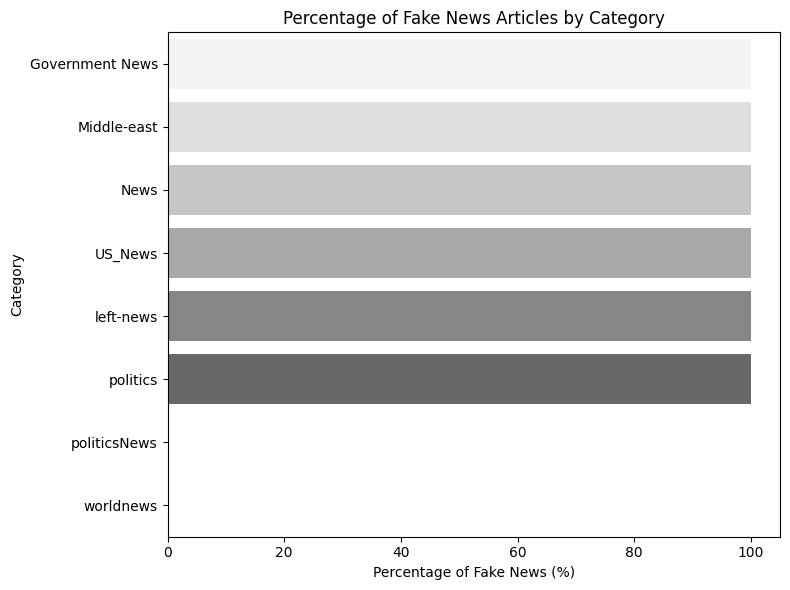

In [19]:
# Calculate percentage of label=1 for each category
category_percent_fake = news_df_subset4.groupby('category')['label'].mean()*100

# Plot horizontal bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=category_percent_fake.values, y=category_percent_fake.index, palette='Greys')
plt.xlabel('Percentage of Fake News (%)')
plt.ylabel('Category')
plt.title('Percentage of Fake News Articles by Category')
plt.tight_layout()
plt.show()

We observe that the **category** feature is perfectly correlated with the fake/real classification, likely due to the fact that the fake and real news articles originated from separate datasets.

**Category** will not be used as a predictive feature but to assess model performance over different domains of content. We allocate the categories to domains as follows:
* news (*worldnews*, *News*, *US_News*, *Middle-east*)
* politics (*politicsNews*, *left-news*, *politics*, *Government News*)
* other

It should be noted that we decide not to allocate any articles to 'other' since there are only two categories of real news.

In [ ]:
# Define the mapping dictionary
category_to_domain = {
    'worldnews': 'news',
    'News': 'news',
    'US_News': 'news',
    'Middle-east': 'news',
    'politicsNews': 'politics',
    'left-news': 'politics',
    'politics': 'politics',
    'Government News': 'politics'
}

# Create the new 'domain' column by mapping the 'category' values
news_df_subset4['domain'] = news_df_subset4['category'].map(category_to_domain).fillna('other')


### 2.4 Temporal Distribution Analysis

We plot a histogram to visualise the distribution of articles over time.

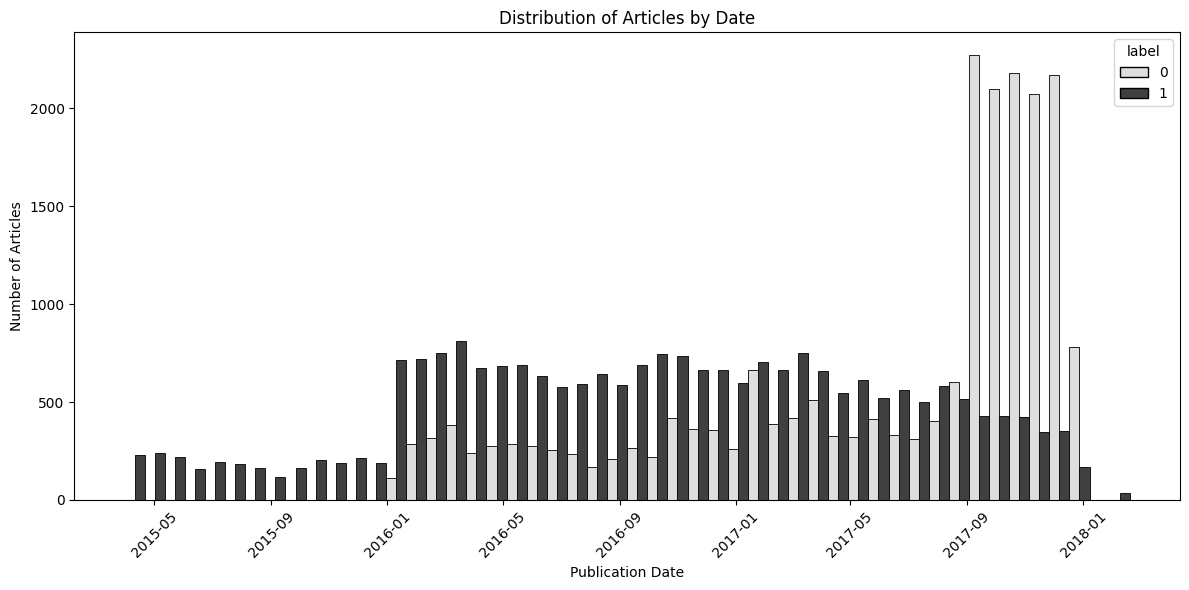

In [20]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=news_df_subset4, 
    x='publication_date', 
    hue='label', 
    bins=50, 
    multiple='dodge',
    palette={1: 'black', 0: 'lightgrey'}
    )
plt.title('Distribution of Articles by Date')
plt.xlabel('Publication Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Earliest and latest publication dates for fake news
fake_min = news_df_subset4[news_df_subset4['label'] == 1]['publication_date'].min()
fake_max = news_df_subset4[news_df_subset4['label'] == 1]['publication_date'].max()
print(f"Fake news articles range from {fake_min} to {fake_max}")

# Earliest and latest publication dates for real news
real_min = news_df_subset4[news_df_subset4['label'] == 0]['publication_date'].min()
real_max = news_df_subset4[news_df_subset4['label'] == 0]['publication_date'].max()
print(f"Real news articles range from {real_min} to {real_max}")

Fake news articles range from 2015-03-31 00:00:00 to 2018-02-19 00:00:00
Real news articles range from 2016-01-13 00:00:00 to 2017-12-31 00:00:00


We observe that real news is generally under-represented prior to September 2017 and significantly over-represented thereafter. More importantly, both classes (real and fake) are not represented across the full timespan of the dataset.

To improve class comparability with respect to **publication_date** - a feature likely to influence article/headline content - we restrict the dataset to articles published between **2016-01-13** and **2017-12-31**, inclusive. Articles falling outside this range are excluded.

In [22]:
# Filter out articles published before 2016-01-13 and after 2017-12-31
news_df_subset5 = news_df_subset4[
    (news_df_subset4['publication_date'] >= '2016-01-13') &
    (news_df_subset4['publication_date'] <= '2017-12-31')
    ].copy()

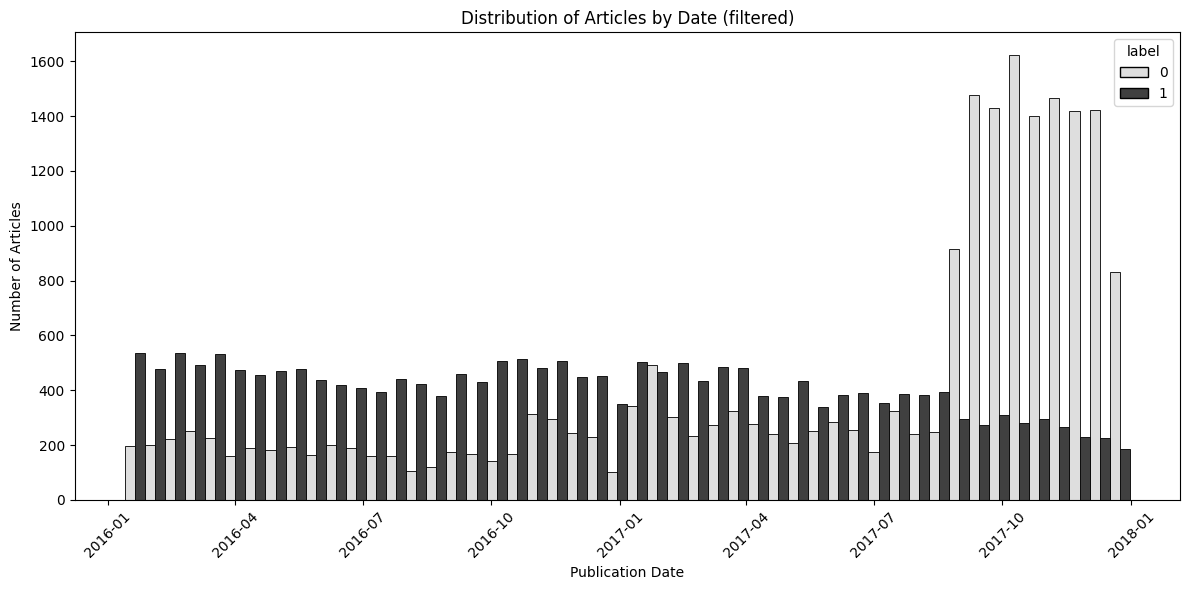

In [23]:
# Plot histogram of new subset
plt.figure(figsize=(12, 6))
sns.histplot(
    data=news_df_subset5, 
    x='publication_date', 
    hue='label', 
    bins=50, 
    multiple='dodge',
    palette={1: 'black', 0: 'lightgrey'}
    )
plt.title('Distribution of Articles by Date (filtered)')
plt.xlabel('Publication Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.5 Feature Engineering
#### 2.5.1 Text Length

Before vectorizing the text for our baseline model, we extract simple features from each article’s headline and body. First, we create new columns to quantify the length of each article’s headline and text by both word and character count and plot these distributions.

In [24]:
# Add character count columns
news_df_subset5['headline_chars_count'] = news_df_subset5['headline'].str.len()
news_df_subset5['article_chars_count'] = news_df_subset5['article_text'].str.len()

# Add word count columns
news_df_subset5['headline_word_count'] = news_df_subset5['headline'].str.split().str.len()
news_df_subset5['article_word_count'] = news_df_subset5['article_text'].str.split().str.len()

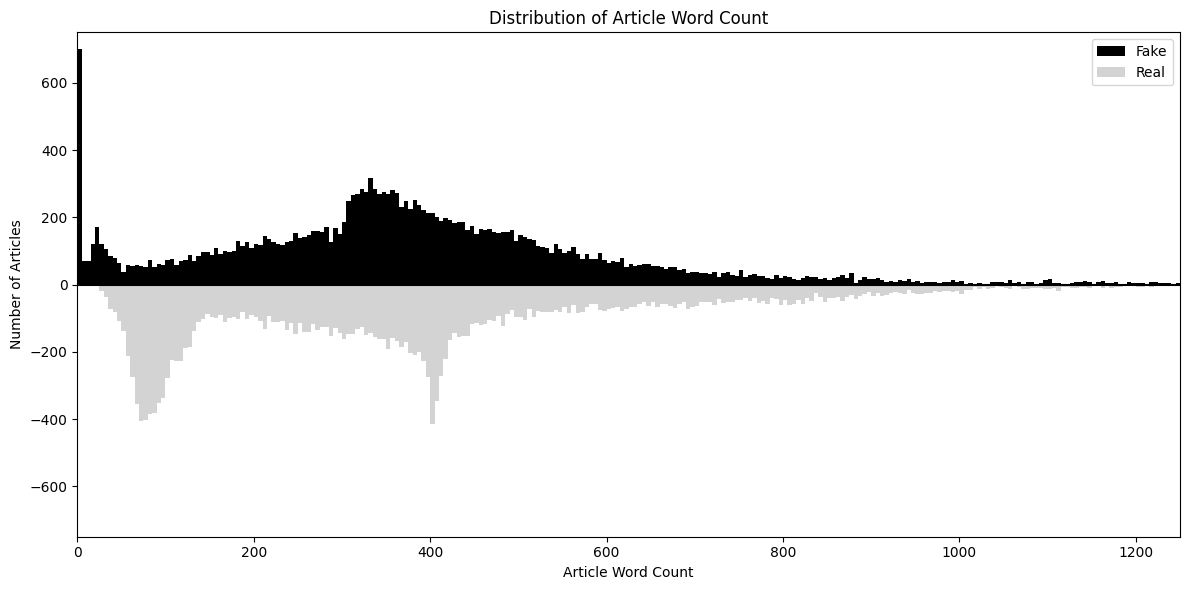

In [25]:
# Extract article word counts by label
real_word_counts = news_df_subset5[news_df_subset5['label'] == 0]['article_word_count']
fake_word_counts = news_df_subset5[news_df_subset5['label'] == 1]['article_word_count']

# Define bins
bins = np.linspace(0, 1250, 251)

# Compute histograms (counts)
real_counts, _ = np.histogram(real_word_counts, bins=bins)
fake_counts, _ = np.histogram(fake_word_counts, bins=bins)

bin_centers = (bins[:-1] + bins[1:]) / 2
width = bins[1] - bins[0]

plt.figure(figsize=(12, 6))

# Plot fake counts as positive bars
plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')

# Plot fake counts as negative bars (mirrored)
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('Article Word Count')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Word Count')
plt.xlim(0, 1250)
plt.ylim(-750, 750)
plt.axhline(0, color='black')

plt.legend()
plt.tight_layout()
plt.show()

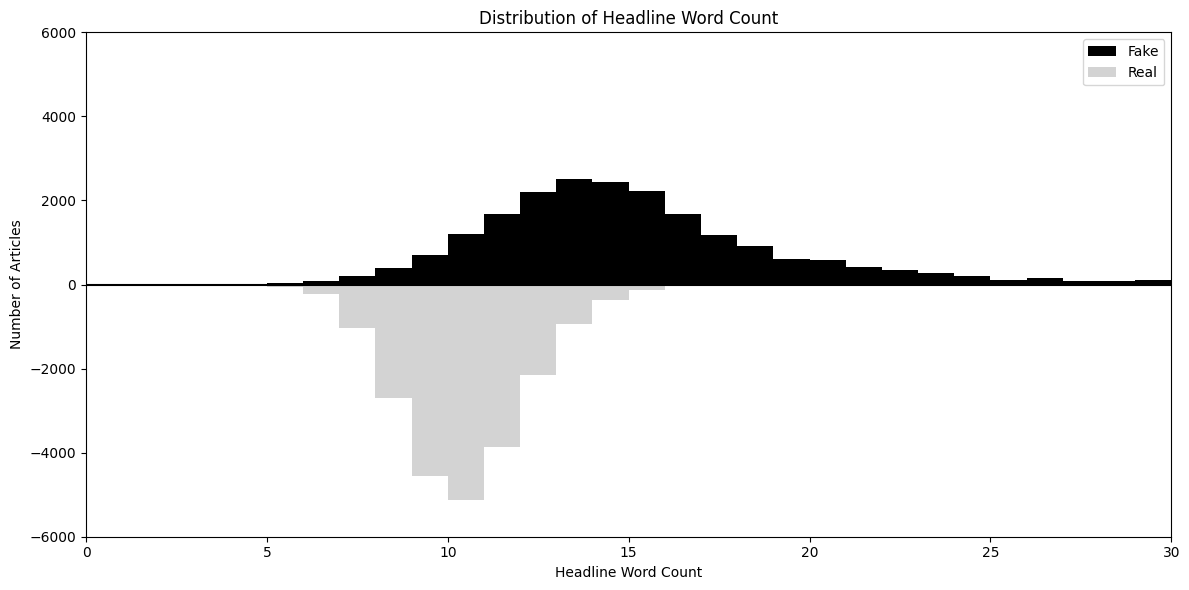

In [26]:
# Extract headline word counts by label
real_word_counts = news_df_subset5[news_df_subset5['label'] == 0]['headline_word_count']
fake_word_counts = news_df_subset5[news_df_subset5['label'] == 1]['headline_word_count']

# Define bins
bins = np.arange(0, 31, 1)

# Compute histograms (counts)
real_counts, _ = np.histogram(real_word_counts, bins=bins)
fake_counts, _ = np.histogram(fake_word_counts, bins=bins)

bin_centers = (bins[:-1] + bins[1:]) / 2
width = 1

plt.figure(figsize=(12, 6))

# Plot fake counts as positive bars
plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')

# Plot fake counts as negative bars (mirrored)
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('Headline Word Count')
plt.ylabel('Number of Articles')
plt.title('Distribution of Headline Word Count')
plt.xlim(0, 30)
plt.ylim(-6000, 6000)
plt.axhline(0, color='black')

plt.legend()
plt.tight_layout()
plt.show()

We observe notable differences in the distributions of headline word count between the two classes (real and fake news).

#### 2.5.2 Special Characters
We create columns to quantify the percentage of special characters !@£$%^&*() in the article headline and text.

In [27]:
# Define special characters
special_chars = r'[!@£$%^&*()]'

# Calculate % of special characters in headline
news_df_subset5['headline_special_chars'] = news_df_subset5['headline'].str.count(special_chars) / news_df_subset5['headline_chars_count'] * 100

# Calculate % of special characters in article text
news_df_subset5['article_special_chars'] = news_df_subset5['article_text'].str.count(special_chars) / news_df_subset5['article_chars_count'] * 100

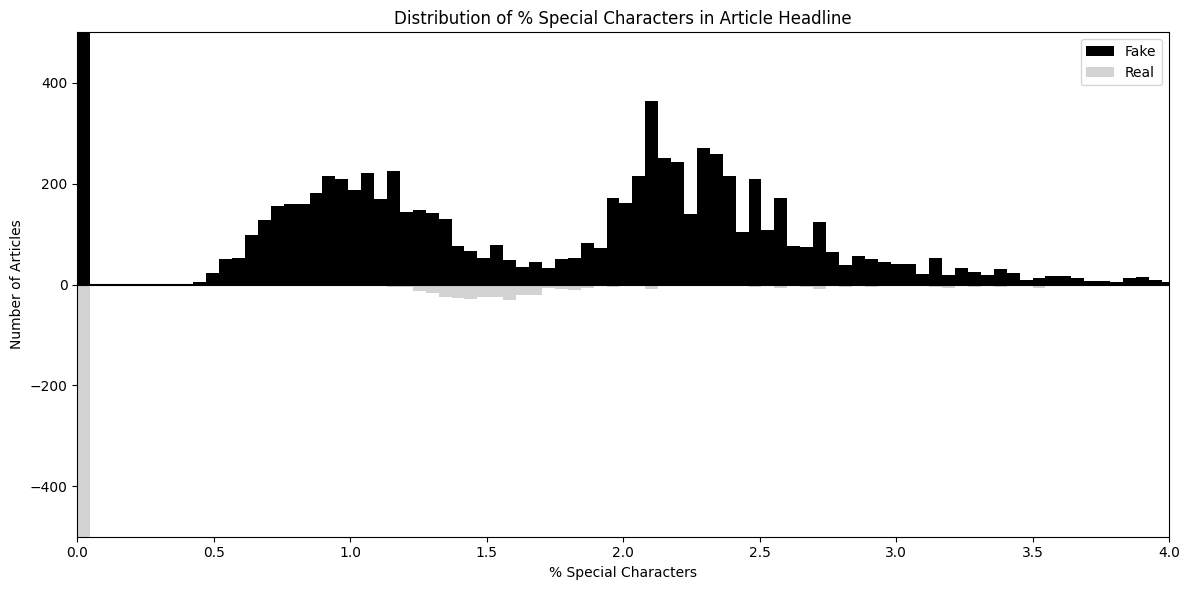

In [28]:
# Extract % special character in headline by label
real_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 0]['headline_special_chars']
fake_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 1]['headline_special_chars']

# Set number of bins
num_bins = 200
combined = np.concatenate([real_spec_char_counts, fake_spec_char_counts])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)

# Compute histograms (counts)
real_counts, _ = np.histogram(real_spec_char_counts, bins=bins)
fake_counts, _ = np.histogram(fake_spec_char_counts, bins=bins)

# Compute bin centers and bar width
bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

# Plot
plt.figure(figsize=(12, 6))

# Plot fake counts as positive bars
plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')

# Plot real counts as negative bars (mirrored)
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Special Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of % Special Characters in Article Headline')
plt.xlim(0, 4)
plt.ylim(-500, 500)
plt.axhline(0, color='black')

plt.legend()
plt.tight_layout()
plt.show()

/Users/dpb24/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


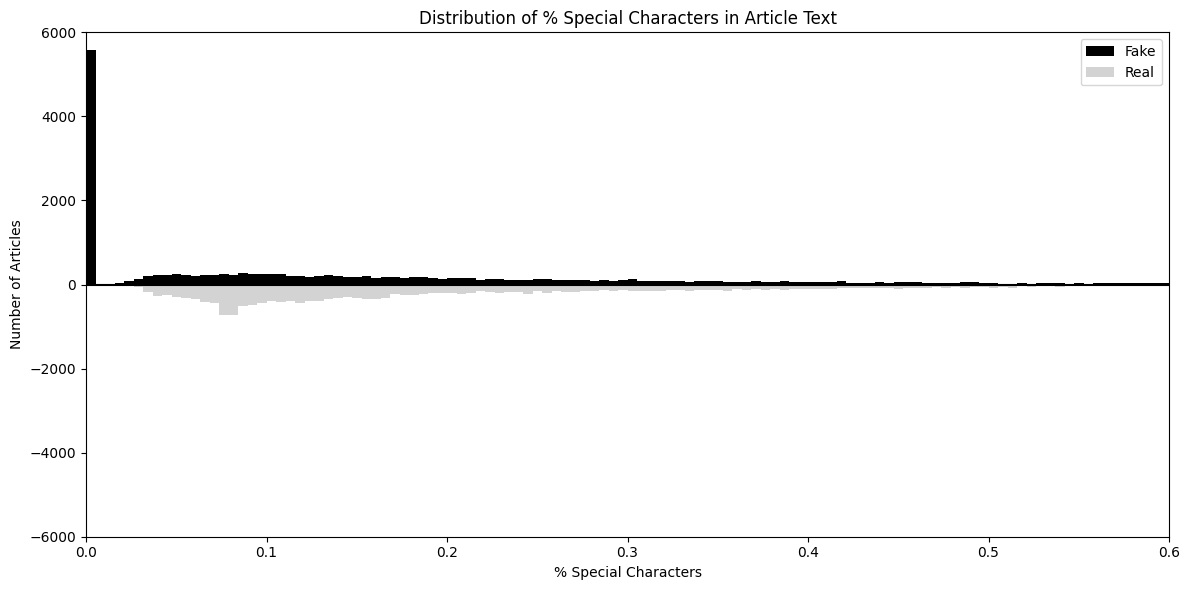

In [29]:
# Extract % special character in article by label
real_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 0]['article_special_chars']
fake_spec_char_counts = news_df_subset5[news_df_subset5['label'] == 1]['article_special_chars']

# Set number of bins
num_bins = 5000
combined = np.concatenate([real_spec_char_counts, fake_spec_char_counts])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)

# Compute histograms (counts)
real_counts, _ = np.histogram(real_spec_char_counts, bins=bins)
fake_counts, _ = np.histogram(fake_spec_char_counts, bins=bins)

# Compute bin centers and bar width
bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

# Plot
plt.figure(figsize=(12, 6))

# Plot fake counts as positive bars
plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')

# Plot real counts as negative bars (mirrored)
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Special Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of % Special Characters in Article Text')
plt.xlim(0, 0.6)
plt.ylim(-6000, 6000)
plt.axhline(0, color='black')

plt.legend()
plt.tight_layout()
plt.show()

We observe notable differences in the distributions of the percentage of special characters in article headlines between real and fake news classes.

#### 2.5.3 Capitalised characters
Finally, we create new columns to quantify the percentage of capitalised characters in both the article headline and the main text.

In [30]:
# Calculate % of capitalised characters in headline
news_df_subset5['headline_capitalised'] = (news_df_subset5['headline'].str.count(r'[A-Z]') / news_df_subset5['headline_chars_count']) * 100

# Calculate % of capitalised characters in article text
news_df_subset5['article_capitalised'] = (news_df_subset5['article_text'].str.count(r'[A-Z]') / news_df_subset5['article_chars_count']) * 100

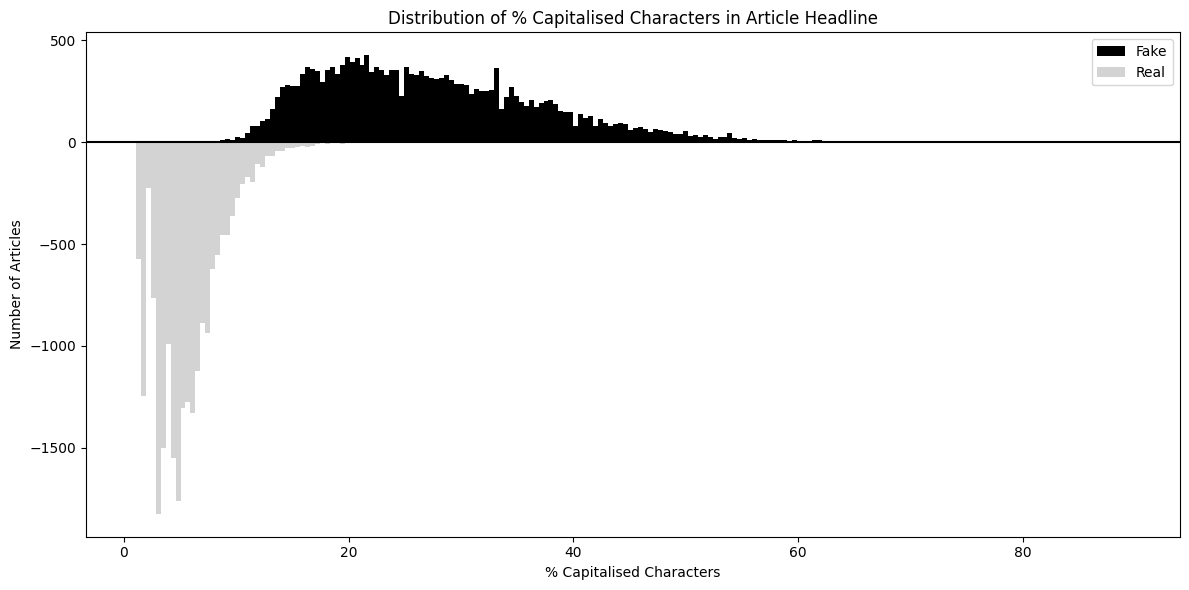

In [31]:
# Extract % capitalised % special character in headline by label
real_capitalised = news_df_subset5[news_df_subset5['label'] == 0]['headline_capitalised']
fake_capitalised = news_df_subset5[news_df_subset5['label'] == 1]['headline_capitalised']

# Set number of bins
num_bins = 200
combined = np.concatenate([real_capitalised, fake_capitalised])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)

# Compute histograms (counts)
real_counts, _ = np.histogram(real_capitalised, bins=bins)
fake_counts, _ = np.histogram(fake_capitalised, bins=bins)

# Compute bin centers and bar width
bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

# Plot
plt.figure(figsize=(12, 6))

# Plot fake counts as positive bars
plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')

# Plot real counts as negative bars (mirrored)
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Capitalised Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of % Capitalised Characters in Article Headline')
plt.axhline(0, color='black')

plt.legend()
plt.tight_layout()
plt.show()

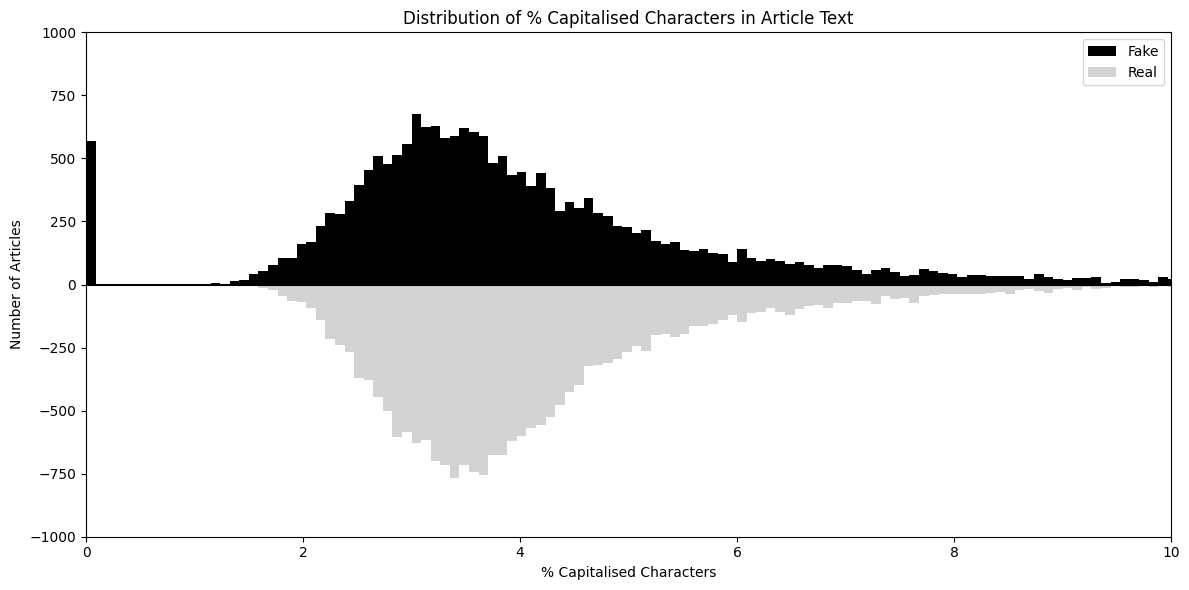

In [32]:
# Extract % capitalised % special character in article text by label
real_capitalised = news_df_subset5[news_df_subset5['label'] == 0]['article_capitalised']
fake_capitalised = news_df_subset5[news_df_subset5['label'] == 1]['article_capitalised']

# Set number of bins
num_bins = 1000
combined = np.concatenate([real_capitalised, fake_capitalised])
bins = np.linspace(combined.min(), combined.max(), num_bins + 1)

# Compute histograms (counts)
real_counts, _ = np.histogram(real_capitalised, bins=bins)
fake_counts, _ = np.histogram(fake_capitalised, bins=bins)

# Compute bin centers and bar width
bin_centers = (bins[:-1] + bins[1:]) / 2
width = np.diff(bins)[0]

# Plot
plt.figure(figsize=(12, 6))

# Plot fake counts as positive bars
plt.bar(bin_centers, fake_counts, width=width, color='black', label='Fake')

# Plot real counts as negative bars (mirrored)
plt.bar(bin_centers, -real_counts, width=width, color='lightgrey', label='Real')

plt.xlabel('% Capitalised Characters')
plt.ylabel('Number of Articles')
plt.title('Distribution of % Capitalised Characters in Article Text')
plt.xlim(0, 10)
plt.ylim(-1000, 1000)
plt.axhline(0, color='black')

plt.legend()
plt.tight_layout()
plt.show()

We observe notable differences in the distributions of the percentage of capitalised characters in article text between real and fake news classes.

#### 2.5.4 Text vectorization

We now implement Bag of Words (BoW) text vectorization method which is a foundational technique in Natural Language Processing (NLP) for converting text into a numerical format.

We create a new column combining **headline** and **article_text**.

In [33]:
# Create new column combined headline and article text
news_df_subset5['combined_text'] = news_df_subset5['headline'] + ' ' + news_df_subset5['article_text']


We initialise the *scikit-learn* CountVectorizer object, specifying the built-in list of English stop words (common words such as "and", "the", etc) to be excluded. We also set a feature limit to retain only the top 5,000 most frequent words in the Bag-of-Words model.

In [34]:
# Create CountVectorizer Object
vectorizer = CountVectorizer(stop_words='english', max_features=5000)

We apply the CountVectorizer to the **combined_text** column to convert the text data into a matrix of token counts.

In [35]:
# Fit and transform the text
vectorized_text = vectorizer.fit_transform(news_df_subset5['combined_text'])

In [36]:
# Convert to vectorized text to DataFrame
vectorized_text_df = pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names_out())

# Check shape of vectorized text DataFrame
vectorized_text_df.shape

(41754, 5000)

In [37]:
# Check shape of pre-vectorized text DataFrame
news_df_subset5.shape

(41754, 14)

## 3 Baseline Model Construction

We begin by building two baseline Machine Learning models — Decision Tree and XGBoost — to classify news articles using a combined set of features that includes both text-based representations (Bag-of-Words) and engineered numerical features.

The Decision Tree model is fast to train and highly interpretable, making it an ideal starting point for baseline evaluation. However, it is prone to overfitting and generally offers lower predictive performance compared to ensemble and more advanced models.

XGBoost is known for delivering high accuracy and includes built-in regularization mechanisms that improve robustness to overfitting. It is highly scalable and efficient, making it suitable for both small and large datasets. While it offers insight into feature importance, its interpretability is lower than that of a single decision tree.

If time permits, we also intend to build a Support Vector Machine (SVM) model. According to the literature, SVMs handle high-dimensional and sparse data effectively, are robust to overfitting, and often perform strongly in text classification tasks.

### 3.1 Final Feature Selection

To ensure efficient model training, we include only engineered features that demonstrated a meaningful difference between classes during exploratory analysis.

We exclude the article **category** feature because it is an artefact of the dataset and would limit application of our model which we wish to rely solely on features derivable from the headline or article text.

| Target ($y$)                      | Features ($x_i$)|
|---------------------------------------------|----------------------------------------|
| **label** (0 = real, 1 = fake) |  Bag of Words vectorized text representation  |
|                 |  **headline_special_chars** (numeric)  |
|                 |  **headline_capitalised** (numeric)    |

### 3.2 Split the data
We assign the target variable and isolate the relevant features that will be used by the Machine Learning models.

In [38]:
# Assign target variable
y = news_df_subset5['label']

# Select engineered numeric features as a DataFrame
engineered_features = news_df_subset5[['headline_special_chars', 'headline_capitalised']]

# Combine vectorized text features and engineered numeric features
X = pd.concat([vectorized_text_df.reset_index(drop=True), engineered_features.reset_index(drop=True)], axis=1)


Split data into training and testing sets, 80/20.

In [39]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [40]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [41]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((25052, 5002), (8351, 5002), (8351, 5002), (25052,), (8351,), (8351,))

### 3.3 Build Baseline Models
#### 3.3.1 Decision Tree

We fit a decision tree classification model to the training set, and hyperparameters are tuned using GridSearchCV, which selects the best model based on the F1 score.

In [42]:
# Instantiate the decision tree classifier
dt = DecisionTreeClassifier(random_state=0)

# Create a dictionary of hyperparameters to search over
cv_params = {'max_depth': [5, 7, None],
             'max_features': ['sqrt', 0.3, 0.6],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 3],
             }

# Define scoring metrics for classification
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object for cross-validation
dt_cv = GridSearchCV(
    estimator=dt,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,
    refit='f1',
    return_train_score=True
    )

In [43]:
%%time
# Fit the model to the training data
dt_cv.fit(X_train, y_train)

CPU times: user 9min 44s, sys: 10min 36s, total: 20min 21s
Wall time: 25min 14s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None],
                         'max_features': ['sqrt', 0.3, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [44]:
# Examine best score according to the refit metric (F1 score)
dt_cv.best_score_

np.float64(0.9982507167345792)

In [45]:
# Examine best parameters
dt_cv.best_params_

{'max_depth': 5,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [46]:
# Access the GridSearch results and convert it to a pandas df
dt_results_df = pd.DataFrame(dt_cv.cv_results_)

#### 3.3.2 XGBoost

We fit an XGBoost classification model to the training set, and hyperparameters are tuned using GridSearchCV, which selects the best model based on the F1 score.

In [48]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

# Create a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5]
}

# Define scoring metric for GridSearch
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object for cross-validation
xgb_cv = GridSearchCV(
    estimator=xgb,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,
    refit='f1',
    n_jobs=-1
    )

In [ ]:
%%time
# Fit the model to the training data
xgb_cv.fit(X_train, y_train)

/Users/dpb24/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dpb24/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dpb24/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dpb24/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [12:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

In [ ]:
# Examine best score according to the refit metric (F1 score)
xgb_cv.best_score_

In [ ]:
# Examine best parameters
xgb_cv.best_params_

In [ ]:
# Access the GridSearch results and convert it to a pandas df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)

## 4 Baseline Model Evaluation
### 4.1 Results and evaluation
#### 4.1.1 Model selection
We evaluate candidate baseline models on the validation data using metrics (accuracy, precision, recall, F1) both across all domains and stratified by domain.

In [ ]:
# Boolean masks for rows where 'domain' == 'news', 'politics', 'other' in original dataframe
mask_news     = news_df_subset5.loc[X_val.index, 'domain'] == 'news'
mask_politics = news_df_subset5.loc[X_val.index, 'domain'] == 'politics'
mask_other    = news_df_subset5.loc[X_val.index, 'domain'] == 'other'         # I am including this even though we didn't use this category

# Subset X_val and y_val using masks
X_val_news     = X_val.loc[mask_news]
y_val_news     = y_val.loc[mask_news]
X_val_politics = X_val.loc[mask_politics]
y_val_politics = y_val.loc[mask_politics]
X_val_other    = X_val.loc[mask_other]
y_val_other    = y_val.loc[mask_other]

In [ ]:
# Function to calculate evaluation metrics
def get_model_metrics(model, X_data, y_data):
    # Get predictions
    y_pred = model.predict(X_data)
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_data, y_pred)
    precision = precision_score(y_data, y_pred, zero_division=0)
    recall = recall_score(y_data, y_pred, zero_division=0)
    f1 = f1_score(y_data, y_pred, zero_division=0)
    
    # Store metrics in a dictionary
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    
    return metrics

# Machine Learning models
models = {
    "Decision Tree": dt_cv.best_estimator_,
    "XGBoost": xgb_cv.best_estimator_
}

# Domains and corresponding subsets
domain_subsets = {
    "all": (X_val, y_val),
    "news": (X_val_news, y_val_news),
    "politics": (X_val_politics, y_val_politics),
    "other": (X_val_other, y_val_other)
}

# Create an empty list to store metrics for each model and domain
results = []

# Loop over each domain subset and each model to calculate metrics
for domain_name, (X_sub, y_sub) in domain_subsets.items():
    for model_name, model in models.items():
        # Skip if subset is empty
        if X_sub.empty or y_sub.empty:
            continue
        
        # Calculate metrics on the subset
        metrics = get_model_metrics(model, X_sub, y_sub)
        
        # Add model and domain info
        metrics["Model"] = model_name
        metrics["Domain"] = domain_name
        
        # Append to results list
        results.append(metrics)

# Convert list of results into a DataFrame
results_df = pd.DataFrame(results)

# Reorder columns for readability (adjust based on your metric keys)
results_df = results_df[["Model", "Domain", "Accuracy", "Precision", "Recall", "F1 Score"]]

# Display results
results_df